In [1]:
import numpy as np
import re, os
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
parent_dir = os.path.abspath(os.path.dirname(os.getcwd()))

In [3]:
def get_mean_roc(data, label_column=0, score_column=1):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(len(data)):
        fpr, tpr, thresholds = roc_curve(data[i][:, label_column], data[i][:, score_column])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_auc = np.std(aucs)
    return mean_fpr, mean_tpr, std_auc, tprs

In [4]:
def read_pre_res_(filepath):
    with open(filepath) as f:
        records = f.readlines()
        f.close()
        all_line_res = []
        res = []
        for i in records:
            all_line_res.append(i.rstrip().split('\t') if i.rstrip() != '' else None)
        start_index = []
        for index,value in enumerate(all_line_res):
            if 'result' in value[0]:
                start_index.append(index)
            else:
                pass
        max_ = 0
        for n in range(len(start_index)-2):
            now_ = start_index[n+1]-start_index[n]-1
            if now_>max_:
                max_=now_
        for m in range(len(start_index)-2):
            fold_res = []
            for i in range(start_index[m]+1,start_index[m+1]):
                fold_res.append(all_line_res[i])
            if len(fold_res)<max_:
                for i in range(max_-len(fold_res)):
                    fold_res.append(['0', '0.0000000000000000'])
                res.append(fold_res)
            else:
                res.append(fold_res)
    return np.array(res).astype(np.float64)

In [5]:
def read_pre_res(filepath):
    with open(filepath) as f:
        records = f.readlines()
        f.close()
        res = []
        for i in records:
            if 'fold ' in i:
                fold_res = []
                res.append(fold_res)
                continue
            fold_res.append(i.rstrip().split('\t') if i.rstrip() != '' else None)
    return np.array(res).astype(np.float64)

In [14]:
file_name = ['zscale_pre_ind.txt','zscale_pre_cv.txt']
RSCNNpath = os.path.join(parent_dir, r'Results\RSCNN_ZScale')

In [15]:
RSCNN_ZScale_Ind = os.path.join(RSCNNpath, file_name[0])
RSCNN_ZScale_Cv = os.path.join(RSCNNpath, file_name[1])

In [16]:
iSUMOK_PseAAC_Cv = os.path.join(parent_dir, r'Data\Compare\my_iSUMOK\train_pre_cv.txt')
iSUMOK_PseAAC_Ind = os.path.join(parent_dir, r'Data\Compare\my_iSUMOK\test_pre_ind.txt')
SUMO_Forest_Cv = os.path.join(parent_dir, r'Data\Compare\my_Forest\new_my_forest_pre_cv.txt')
SUMO_Forest_Ind = os.path.join(parent_dir, r'Data\Compare\my_Forest\new_my_forest_pre_ind.txt')

In [17]:
path = [iSUMOK_PseAAC_Cv,SUMO_Forest_Cv,RSCNN_ZScale_Cv]

In [18]:
fprs = []
tprs = []
stds = []
TPRS = []
for p in path:
    predict_cv_res = read_pre_res(p)
    fpr, tpr, std, Tprs = get_mean_roc(predict_cv_res)
    fprs.append(fpr)
    tprs.append(tpr)
    stds.append(std)
    TPRS.append(Tprs)

In [19]:
code = ['iSUMOK-PseAAC','SUMO-Forest','ResSUMO']

In [20]:
plt.rcParams['savefig.dpi'] = 600

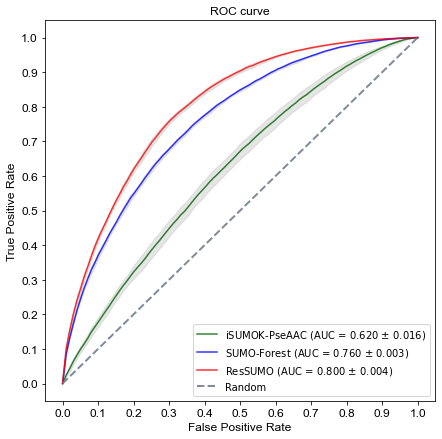

In [21]:
colors = cycle(['darkgreen', 'blue', 'red', 'purple', 'crimson', 'silver', 'magenta'])
fig = plt.figure(figsize=(7,7))
plt.title('ROC curve', fontdict={'family':'Arial','size' : 12})
for i, color in zip(range(len(fprs)), colors):
    mean_auc = auc(fprs[i], tprs[i])
    plt.plot(fprs[i], tprs[i], lw=1.5, alpha=0.8, color=color,
                 label='%s (AUC = %0.3f $\pm$ %0.3f)' % (code[i], mean_auc, stds[i]))
    std_tpr = np.std(TPRS[i], axis=0)
    tprs_upper = np.minimum(tprs[i] + std_tpr, 1)
    tprs_lower = np.maximum(tprs[i] - std_tpr, 0)
    if i ==5:
        plt.fill_between(fprs[i], tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
    else:
        plt.fill_between(fprs[i], tprs_lower, tprs_upper, color='grey', alpha=.2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='slategray',
         label='Random', alpha=.9)
plt.xticks(np.arange(0, 1.1, 0.1),fontproperties = 'Arial', size = 12)
plt.yticks(np.arange(0, 1.1, 0.1),fontproperties = 'Arial', size = 12)
plt.xlabel('False Positive Rate', fontdict={'family':'Arial','size' : 12})
plt.ylabel('True Positive Rate', fontdict={'family':'Arial','size' : 12})
plt.legend(loc="lower right")
plt.close(0)